In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier




In [2]:
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
events_data = pd.read_csv("./models/event_data_train.csv") 
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [4]:
submissions_data = pd.read_csv('./models/submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [7]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [8]:
events_data['day'] = events_data.date.dt.date

In [9]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [10]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

<AxesSubplot:xlabel='day'>

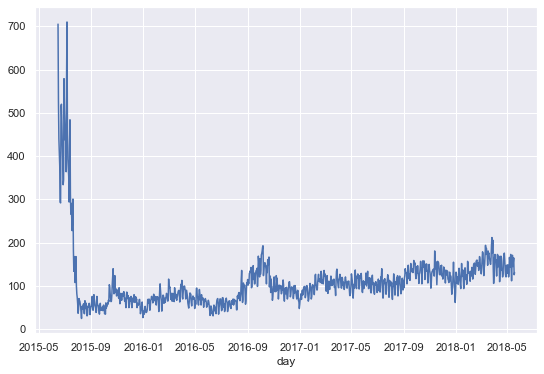

In [11]:
events_data.groupby('day') \
    .user_id.nunique().plot()

In [12]:
# events_data[events_data.action == 'passed'] \
#     .groupby('user_id', as_index=False) \
#     .agg({'step_id': 'count'}) \
#     .rename(columns={'step_id': 'passed_steps'}) \
#     .head()

In [13]:
users_event_data = events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [14]:
users_score = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_score.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [15]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [16]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [17]:
gap_data = gap_data / (24 * 60 * 60)


In [18]:
gap_data.quantile(0.9)

18.325995370370403

In [19]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [20]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})

In [21]:
final_day = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60

In [22]:
users_data['is_gone_user'] = (final_day - users_data.last_timestamp) > drop_out_treshold

In [23]:
users_data = users_data.merge(users_score, on='user_id', how='outer')

In [24]:
users_data = users_data.fillna(0)

In [25]:
users_data = users_data.merge(users_event_data, on='user_id', how='outer')

In [26]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [27]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [28]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

data integrity check

In [29]:

users_data.user_id.nunique()


19234

In [30]:
events_data.user_id.nunique()

19234

In [31]:
users_data['passed_course'] = users_data.passed > 170

In [32]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [33]:
passed_stat = (1425 / 17809) * 100
passed_stat

8.001572238755687

In [34]:
first_user_action = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [35]:
users_data = users_data.merge(first_user_action, on='user_id', how='outer')

In [36]:
# events_data_train = pd.DataFrame()

In [37]:
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_treshold = min_user_time + 3 * 24 * 60 * 60

#     user_event_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]

#     events_data_train = events_data_train.append(user_event_data)




In [38]:
# events_data_train.head()

In [ ]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [ ]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

In [ ]:
user_learning_time_treshold = first_user_action.user_id.map(str) + '_' + (first_user_action.min_timestamp + learning_time_treshold).map(str)

In [ ]:
first_user_action['user_learning_time_treshold'] = user_learning_time_treshold

In [ ]:
events_data = events_data.merge(first_user_action[['user_id', 'user_learning_time_treshold']], how='outer')

In [ ]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [ ]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [ ]:
max_step_id = submissions_data.step_id.max()

In [ ]:
wrong_sub_data = submissions_data[submissions_data.submission_status == 'wrong']

In [ ]:
wrong_sub_data = wrong_sub_data.groupby('step_id', as_index=False) \
    .agg({'submission_status': 'count'}) \
    .sort_values(['submission_status'], ascending=False)

In [ ]:
wrong_sub_data.head(1)

,step_id,submission_status
4,31978,16084


In [ ]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [ ]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(first_user_action[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [ ]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149,15853_1434605177
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177


In [ ]:
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False,1480603427
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False,1484999434
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False,1526140624
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False,1436366155
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True,1435674765


In [ ]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [ ]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [ ]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [ ]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                   columns='submission_status',
                                   values='step_id',
                                   aggfunc='count',
                                   fill_value=0
                                  ).reset_index())
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [ ]:
X['correct_rating'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_rating
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [ ]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                   columns='action',
                                   values='step_id',
                                   aggfunc='count',
                                   fill_value=0
                                  ).reset_index()[['user_id', 'viewed']], how='outer')
X = X.fillna(0)
X.head()

,user_id,days,steps_tried,correct,wrong,correct_rating,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [ ]:
X = X.merge(users_data[['user_id','passed_course', 'is_gone_user']], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_rating,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [ ]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]
X.shape

(17985, 9)

In [ ]:
y = X.passed_course.map(int)

In [ ]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [ ]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_rating,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


decision tree prediction

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.50)


In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [ ]:
predictions_not_grid = clf.predict(X_test)


In [ ]:
clf.score(X_train, y_train)

0.9188167259786477

In [ ]:
precision_score(y_test, predictions_not_grid)


/Users/user/opt/anaconda3/envs/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
recall_score(y_test, predictions_not_grid)

0.0

In [ ]:
params = {"max_depth": range(1, 10), "criterion": ['entropy', 'gini'], "min_samples_split": range(2, 5), "min_samples_leaf": range(1, 5)}

In [ ]:
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [ ]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5)})

In [ ]:
grid_search_cv_clf.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

[Text(0.5, 0.75, 'X[2] <= 7.5\nentropy = 0.406\nsamples = 8992\nvalue = [8262, 730]'),
 Text(0.25, 0.25, 'entropy = 0.21\nsamples = 7359\nvalue = [7115, 244]'),
 Text(0.75, 0.25, 'entropy = 0.878\nsamples = 1633\nvalue = [1147, 486]')]

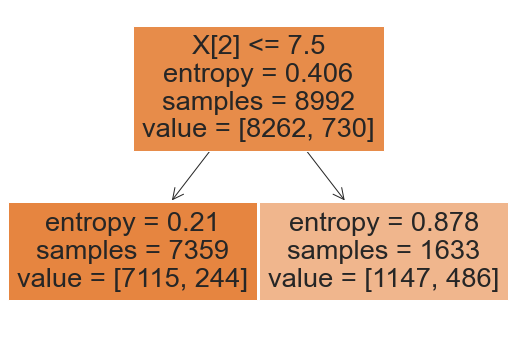

In [ ]:
tree.plot_tree(clf, filled=True)

In [ ]:
predictions = grid_search_cv_clf.best_estimator_.predict(X_test)
precision_score(y_test, predictions)

0.6329113924050633

In [ ]:
grid_search_cv_clf.score(X_test, y_test)

0.9250528188591126

In [ ]:
recall_score(y_test, predictions)

0.07194244604316546

In [ ]:
predictions_train = grid_search_cv_clf.best_estimator_.predict(X_train)
precision_score(y_train, predictions_train)

0.7037037037037037

In [ ]:
recall_score(y_train, predictions_train)

0.07808219178082192

In [ ]:
predictions_ser = pd.Series(predictions)
predictions_ser = predictions_ser.to_frame()
# predictions_ser[predictions_ser[0] == 1].count()
predictions_ser = predictions_ser.rename(columns={0: 'qwe'})
predictions_ser.qwe.value_counts()

0    8914
1      79
Name: qwe, dtype: int64

In [ ]:
clf_rf = RandomForestClassifier()

In [ ]:
rf_params =  {"n_estimators": [10, 20, 30], "max_depth": [2, 5, 7, 10]}

In [ ]:
grid_search_cv_rf_clf = GridSearchCV(clf_rf, rf_params, cv=5)

In [ ]:
grid_search_cv_rf_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [ ]:
grid_search_cv_rf_clf.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [ ]:
predict_rf = grid_search_cv_rf_clf.predict(X_test)

In [ ]:
grid_search_cv_rf_clf.score(X_test, y_test)

0.9250528188591126

In [ ]:
precision_score(y_test, predict_rf)

0.6105263157894737

In [ ]:
recall_score(y_test, predict_rf)

0.08345323741007195

In [ ]:
submissions_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')

In [ ]:
submissions_data_test.user_id.nunique()

2803

In [ ]:
events_data_test.user_id.nunique()

6184

In [ ]:
submissions_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [ ]:
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [ ]:
users_event_data = events_data_test.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_event_data

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105
...,...,...,...,...,...
6179,26791,1,1,0,1
6180,26795,1,1,0,1
6181,26796,6,4,2,12
6182,26799,6,6,2,6


In [ ]:
user_submissions_data = submissions_data_test.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
user_submissions_data

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35
...,...,...,...
2798,26775,46,160
2799,26780,16,7
2800,26785,3,1
2801,26796,2,3


In [ ]:
final_table = events_data_test.merge(user_submissions_data, how='outer', on='user_id')

In [ ]:
final_table = final_table.merge(users_event_data, how='outer', on='user_id')

In [ ]:
final_table = final_table.groupby('user_id', as_index=False) \
    .agg({'passed' : 'max', 'discovered' : 'max', 'started_attempt': 'max', 'viewed': 'max',
    'step_id': 'nunique', 'correct': 'max', 'wrong': 'max'}) \
    .rename(columns={'step_id': 'unique_steps_count'})

In [ ]:
final_table = final_table.fillna(0).astype('int64')

In [ ]:
# final_table['is_gone'] = final_table.passed >= 40

In [ ]:
final_table

,user_id,passed,discovered,started_attempt,viewed,unique_steps_count,correct,wrong
0,4,1,1,0,1,1,0,0
1,6,1,1,0,1,1,0,0
2,10,2,2,0,6,2,0,0
3,12,9,11,4,14,12,1,0
4,13,70,70,35,105,70,29,36
...,...,...,...,...,...,...,...,...
6179,26791,1,1,0,1,1,0,0
6180,26795,1,1,0,1,1,0,0
6181,26796,4,6,2,12,6,2,3
6182,26799,6,6,2,6,6,2,0


In [ ]:
is_gone_predict = final_table.passed
final_table_train = final_table.drop(columns=['passed'], axis=1)

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
params = {"n_estimators": range(10, 50, 10), "max_depth": range(1, 12, 2), "min_samples_leaf": range(1, 7), "min_samples_split": range(2, 9, 2)}

In [ ]:
grid_is_good = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_table_train, is_gone_predict, train_size = 0.75)


In [ ]:
grid_is_good.fit(X_train, y_train)

/Users/user/opt/anaconda3/envs/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 12, 2),
                         'min_samples_leaf': range(1, 7),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': range(10, 50, 10)})

In [ ]:
grid_pred = grid_is_good.predict(X_test)

In [ ]:
grid_is_good.score(X_train, y_train)

0.9473911168607159

In [ ]:
precision_score(y_test, grid_pred)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
recall_score(y_test, grid_pred)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
proba = grid_is_good.predict_proba(final_table_train)

array([10, 12, 12, ..., 41,  0,  1])

In [ ]:
proba

array([[0.02703504, 0.97296496, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02703504, 0.97296496, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.025     , 0.85416667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00833333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00119048, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
df = pd.DataFrame({'user_id': final_table_train.user_id, 'is_gone': proba[:, 1]})

In [ ]:
df.head(40)

,user_id,is_gone
0,4,0.972965
1,6,0.972965
2,10,0.025000
3,12,0.000000
4,13,0.000000
5,15,1.000000
6,19,0.972965
7,21,0.000000
8,23,0.972965
9,35,0.000000
